# 📊 SHAP-only Ablation Study for Inventory-RL
---

**Research Goal**: Xác định đóng góp riêng của feature-based explanation (SHAP) trong khung Inventory-RL

**Quy trình SHAP-only**:
- Tính SHAP values trên chính sách đã học (DQN/A2C với Q-values)
- KHÔNG sử dụng RDX (Reward Decomposition) hoặc MSX
- Chỉ ghi nhận FCS (Feature Coverage Score)

**Agents**: DQN (Double DQN, Per-Product Q-Network) vs A2C_mod (Actor-Critic)  
**Environment**: 220 products, 14 discrete actions

---

## Step 1: Setup & Khởi tạo Agent (Restore Checkpoints)

In [45]:
import os, warnings, time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(edgeitems=10, linewidth=10000, precision=6, suppress=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")

TensorFlow: 2.20.0
NumPy: 2.4.2


In [46]:
# ============================================================
# CONFIGURATION
# ============================================================
NUM_PRODUCTS    = 220
NUM_FEATURES_PP = 3          # per product: [x, sales, q]
NUM_FEATURES    = NUM_PRODUCTS * NUM_FEATURES_PP  # 660
NUM_ACTIONS     = 14
ACTION_SPACE    = np.array([0, 0.005, 0.01, 0.0125, 0.015, 0.0175,
                            0.02, 0.03, 0.04, 0.08, 0.12, 0.2, 0.5, 1],
                           dtype=np.float32)
WASTE_RATE      = 0.025
ZERO_INVENTORY  = 1e-5
GAMMA           = 0.99

# Architecture sizes
DQN_HIDDEN  = 32   # Must match checkpoint architecture (checkpoints_dqn_comparison512_32)
A2C_HIDDEN  = 32
DROPOUT     = 0.1

# Paths - UPDATED
DATA_DIR        = r'C:\NCKH\SHAP\data'
TEST_FILE       = os.path.join(DATA_DIR, 'test.tfrecords')
CAP_FILE        = os.path.join(DATA_DIR, 'capacity.tfrecords')
STOCK_FILE      = os.path.join(DATA_DIR, 'stock.tfrecords')
DQN_CKPT_DIR    = r'C:\NCKH\SHAP\checkpoints_dqn_comparison512_32'
A2C_CKPT_DIR    = r'C:\NCKH\SHAP\outputA2Cmod\checkpoints_a2cmod'

# Feature identifiers for SHAP analysis
FEATURES   = ['inventory', 'sales', 'waste_feat']  # 3 input features per product

print("Configuration ✓")
print(f"  Data directory: {DATA_DIR}")
print(f"  DQN checkpoints: {DQN_CKPT_DIR}")
print(f"  A2C checkpoints: {A2C_CKPT_DIR}")

Configuration ✓
  Data directory: C:\NCKH\SHAP\data
  DQN checkpoints: C:\NCKH\SHAP\checkpoints_dqn_comparison512_32
  A2C checkpoints: C:\NCKH\SHAP\outputA2Cmod\checkpoints_a2cmod


### 1.1 Model Architecture Declarations

In [47]:
# ============================================================
# A2C_mod Model Classes
# ============================================================
# Key: Critic uses tf.keras.layers.GroupNormalization(groups=1)
#      Actor has 4 Dense layers → softmax
#      Both use hidden_size=32, dropout=0.1

class Dense(tf.Module):
    def __init__(self, input_dim, output_size, activation=None, stddev=1.0):
        super(Dense, self).__init__()
        self.w = tf.Variable(
            tf.random.truncated_normal([input_dim, output_size], stddev=stddev), name='w')
        self.b = tf.Variable(tf.zeros([output_size]), name='b')
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation:
            y = self.activation(y)
        return y


class Actor(tf.Module):
    """Policy network: [P, 3] → [P, 14] softmax probabilities."""
    def __init__(self, num_features, num_actions, hidden_size,
                 activation=tf.nn.relu, dropout_prob=0.1):
        super(Actor, self).__init__()
        self.layer1 = Dense(num_features, hidden_size, activation=None)
        self.layer2 = Dense(hidden_size, hidden_size, activation=None)
        self.layer3 = Dense(hidden_size, hidden_size, activation=None)
        self.layer4 = Dense(hidden_size, num_actions, activation=None)
        self.activation = activation
        self.dropout_prob = dropout_prob

    def __call__(self, state):
        x = self.activation(self.layer1(state))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.activation(self.layer2(x))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.activation(self.layer3(x))
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.layer4(x)
        return tf.nn.softmax(x)


class Critic(tf.Module):
    """Value network: [P, 3] → [P] scalar values. Uses GroupNorm."""
    def __init__(self, num_features, hidden_size,
                 activation=tf.nn.relu, dropout_prob=0.1):
        super(Critic, self).__init__()
        self.layer1 = Dense(num_features, hidden_size, activation=None)
        self.layer2 = Dense(hidden_size, 1, activation=None)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.group_norm = tf.keras.layers.GroupNormalization(groups=1)

    def __call__(self, state):
        x = self.layer1(state)
        x = self.group_norm(x)
        x = self.activation(x)
        x = tf.nn.dropout(x, self.dropout_prob)
        x = self.layer2(x)
        return tf.squeeze(x, axis=-1, name='factor_squeeze')

print("A2C_mod classes (Dense, Actor, Critic) defined ✓")

A2C_mod classes (Dense, Actor, Critic) defined ✓


In [48]:
# ============================================================
# DQN Model Class — Per-Product Q-Network
# ============================================================
# Input:  [B, 660]  (flattened: [x_0..x_P, sales_0..sales_P, q_0..q_P])
# Output: [B, 220, 14]

class MultiProductQNetwork(tf.keras.Model):
    """
    Per-Product Q-Network. Each product processed independently.
    """
    def __init__(self, num_features, num_products, num_actions,
                 hidden_size, dropout_prob=0.1, use_group_norm=True, name=None):
        super().__init__(name=name)
        self.num_products      = num_products
        self.num_actions       = num_actions
        self.features_per_prod = num_features // num_products  # 3

        self.dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")
        self.dense2 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense2")
        self.dense3 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense3")
        self.out    = tf.keras.layers.Dense(num_actions,  activation=None, name="output")

        self._use_gn = use_group_norm
        if use_group_norm:
            self.gn1 = tf.keras.layers.GroupNormalization(groups=1, name="gn1")
            self.gn2 = tf.keras.layers.GroupNormalization(groups=1, name="gn2")
            self.gn3 = tf.keras.layers.GroupNormalization(groups=1, name="gn3")

        self.drop1 = tf.keras.layers.Dropout(dropout_prob)
        self.drop2 = tf.keras.layers.Dropout(dropout_prob)
        self.drop3 = tf.keras.layers.Dropout(dropout_prob)

    def call(self, state, training=False):
        B = tf.shape(state)[0]
        P, F = self.num_products, self.features_per_prod
        # [B, 660] → [B, 3, 220] → [B, 220, 3]
        s3d = tf.transpose(tf.reshape(state, [B, F, P]), [0, 2, 1])
        x = tf.reshape(s3d, [B * P, F])

        x = self.dense1(x)
        if self._use_gn: x = self.gn1(x, training=training)
        x = tf.nn.relu(x); x = self.drop1(x, training=training)

        x = self.dense2(x)
        if self._use_gn: x = self.gn2(x, training=training)
        x = tf.nn.relu(x); x = self.drop2(x, training=training)

        x = self.dense3(x)
        if self._use_gn: x = self.gn3(x, training=training)
        x = tf.nn.relu(x); x = self.drop3(x, training=training)

        return tf.reshape(self.out(x), [B, P, self.num_actions])

print("DQN class (MultiProductQNetwork) defined ✓")

DQN class (MultiProductQNetwork) defined ✓


### 1.2 Load Checkpoints

In [49]:
# ============================================================
# load_trained_agents(): Restore both agents from disk
# ============================================================

def load_trained_agents():
    """Load DQN and A2C_mod agents from checkpoints."""

    # ── A2C_mod ──────────────────────────────────────────────
    actor  = Actor(NUM_FEATURES_PP, NUM_ACTIONS, A2C_HIDDEN,
                   activation=tf.nn.relu, dropout_prob=DROPOUT)
    critic = Critic(NUM_FEATURES_PP, A2C_HIDDEN,
                    activation=tf.nn.relu, dropout_prob=DROPOUT)
    # Build with dummy pass
    _d = tf.zeros([1, NUM_FEATURES_PP])
    _ = actor(_d); _ = critic(_d)

    a2c_ckpt = tf.train.Checkpoint(
        critic_optimizer=tf.optimizers.Adam(0.0005),
        actor_optimizer=tf.optimizers.Adam(0.0001),
        critic=critic, actor=actor, step=tf.Variable(0))
    a2c_ckpt.restore(tf.train.latest_checkpoint(A2C_CKPT_DIR)).expect_partial()
    print(f"✅ A2C_mod restored: {tf.train.latest_checkpoint(A2C_CKPT_DIR)}")

    # ── DQN ──────────────────────────────────────────────────
    q_net = MultiProductQNetwork(
        NUM_FEATURES, NUM_PRODUCTS, NUM_ACTIONS,
        DQN_HIDDEN, DROPOUT, use_group_norm=True, name="q_network")
    t_net = MultiProductQNetwork(
        NUM_FEATURES, NUM_PRODUCTS, NUM_ACTIONS,
        DQN_HIDDEN, DROPOUT, use_group_norm=True, name="target_network")
    _d = tf.zeros([1, NUM_FEATURES], dtype=tf.float32)
    _ = q_net(_d, training=False); _ = t_net(_d, training=False)

    dqn_ckpt = tf.train.Checkpoint(
        optimizer=tf.optimizers.Adam(0.001),
        q_network=q_net, target_network=t_net,
        step=tf.Variable(0, dtype=tf.int64))
    dqn_ckpt.restore(tf.train.latest_checkpoint(DQN_CKPT_DIR)).expect_partial()
    print(f"✅ DQN restored: {tf.train.latest_checkpoint(DQN_CKPT_DIR)}")

    return {'actor': actor, 'critic': critic, 'q_network': q_net}

agents = load_trained_agents()

✅ A2C_mod restored: C:\NCKH\SHAP\outputA2Cmod\checkpoints_a2cmod\ckpt-64
✅ DQN restored: C:\NCKH\SHAP\checkpoints_dqn_comparison512_32\ckpt-43


### 1.3 Load Test Data

In [50]:
# ============================================================
# Load TFRecord test data
# ============================================================
def _parse(serialized, key, n):
    return tf.io.parse_single_example(
        serialized, {key: tf.io.FixedLenFeature([n], tf.float32)})[key]

capacity = next(iter(
    tf.data.TFRecordDataset(CAP_FILE).map(lambda s: _parse(s, 'capacity', NUM_PRODUCTS))
)).numpy()

x_init = next(iter(
    tf.data.TFRecordDataset(STOCK_FILE).map(lambda s: _parse(s, 'stock', NUM_PRODUCTS))
)).numpy()

all_sales = []
for rec in tf.data.TFRecordDataset(TEST_FILE).map(lambda s: _parse(s, 'sales', NUM_PRODUCTS)):
    all_sales.append(rec.numpy())
all_sales = np.array(all_sales, dtype=np.float32) / capacity[None, :]
T_MAX = len(all_sales)
print(f"✅ Test data loaded: {T_MAX} timesteps × {NUM_PRODUCTS} products")
print(f"   Capacity shape: {capacity.shape}")
print(f"   Initial stock shape: {x_init.shape}")

✅ Test data loaded: 504 timesteps × 220 products
   Capacity shape: (220,)
   Initial stock shape: (220,)


## Step 2: Background Data Generation & SHAP Preparation

In [51]:
import shap

def generate_background_data(num_samples=200):
    """
    Tạo dữ liệu nền (inventory, sales, waste) mô phỏng môi trường thực tế.
    """
    # Tạo Inventory và Sales độc lập
    inventory = np.random.uniform(0.0, 1.0, size=(num_samples,))
    sales = np.random.uniform(0.0, 1.0, size=(num_samples,))
    
    # Lãng phí có nhiễu ngẫu nhiên
    waste = 0.025 * inventory + np.random.normal(0, 0.005, size=(num_samples,))
    waste = np.clip(waste, 0, 0.1)
    
    X_background = np.column_stack([inventory, sales, waste]).astype(np.float32)
    
    print(f"✓ Tạo background data: {X_background.shape}")
    return X_background

# Tạo background data và sample
background_data = generate_background_data(num_samples=200)
sampled_background = shap.sample(background_data, 100)

print(f"✓ Background data shape: {background_data.shape}")
print(f"✓ Sampled background shape: {sampled_background.shape}")

✓ Tạo background data: (200, 3)
✓ Background data shape: (200, 3)
✓ Sampled background shape: (100, 3)


## Step 3: Predict Wrapper Functions

In [52]:
def dqn_predict(X):
    """
    Wrapper function cho DQN: trả về Q-values cho tất cả actions.
    Input: (batch_size, 3) - [inventory, sales, waste]
    Output: (batch_size, 14) - Q-values cho 14 actions
    """
    if not isinstance(X, np.ndarray):
        X = np.array(X, dtype=np.float32)
    
    # Mở rộng input từ (batch, 3) -> (batch, 660) cho 220 products
    batch_size = X.shape[0]
    X_expanded = np.tile(X, (1, NUM_PRODUCTS))  # (batch, 660)
    
    # Predict Q-values
    q_values = agents['q_network'](X_expanded, training=False)  # (batch, 220, 14)
    
    # Lấy trung bình Q-values qua tất cả products
    q_mean = tf.reduce_mean(q_values, axis=1)  # (batch, 14)
    
    return q_mean.numpy()


def a2c_predict(X):
    """
    Wrapper function cho A2C_mod: trả về action logits.
    Input: (batch_size, 3) - [inventory, sales, waste]
    Output: (batch_size, 14) - logits cho 14 actions
    """
    if not isinstance(X, np.ndarray):
        X = np.array(X, dtype=np.float32)
    
    # Actor expects input per product: (batch, 3) for single product
    # We'll use the input directly since we're analyzing per-product behavior
    logits = agents['actor'](X)  # (batch, 14)
    
    return logits.numpy()


print("✓ Predict wrapper functions created:")
print("  - dqn_predict: DQN Q-values")
print("  - a2c_predict: A2C_mod action logits")

✓ Predict wrapper functions created:
  - dqn_predict: DQN Q-values
  - a2c_predict: A2C_mod action logits


## Step 4: Define Scenarios (EASY, MEDIUM, HARD)

In [53]:
SCENARIOS = {
    "EASY": {
        "sales_scale": 0.5,
        "waste_rate": 0.010,
        "states": [
            np.array([[0.10, 0.50, 0.001]], dtype=np.float32),  # Low inv, medium sales
            np.array([[0.30, 0.60, 0.003]], dtype=np.float32),  # Medium inv, medium sales
            np.array([[0.50, 0.40, 0.005]], dtype=np.float32),  # Medium inv, low sales
        ]
    },
    "MEDIUM": {
        "sales_scale": 1.0,
        "waste_rate": 0.025,
        "states": [
            np.array([[0.15, 0.85, 0.004]], dtype=np.float32),  # Low inv, high sales
            np.array([[0.50, 0.70, 0.013]], dtype=np.float32),  # Medium inv, high sales
            np.array([[0.70, 0.50, 0.018]], dtype=np.float32),  # High inv, medium sales
        ]
    },
    "HARD": {
        "sales_scale": 1.5,
        "waste_rate": 0.050,
        "states": [
            np.array([[0.08, 0.95, 0.002]], dtype=np.float32),  # Very low inv, very high sales
            np.array([[0.60, 0.90, 0.030]], dtype=np.float32),  # High inv, very high sales
            np.array([[0.95, 0.85, 0.048]], dtype=np.float32),  # Very high inv, high sales
        ]
    }
}

FEATURE_NAMES = ['Inventory', 'Sales', 'Waste']
ACTION_NAMES = [
    '0%', '0.5%', '1.0%', '1.25%', '1.5%', 
    '1.75%', '2.0%', '3.0%', '4.0%', '8.0%', 
    '12.0%', '20.0%', '50.0%', '100%'
]

print("✓ Scenarios defined:")
for name, config in SCENARIOS.items():
    print(f"  {name}: sales_scale={config['sales_scale']}, waste_rate={config['waste_rate']}, {len(config['states'])} states")

✓ Scenarios defined:
  EASY: sales_scale=0.5, waste_rate=0.01, 3 states
  MEDIUM: sales_scale=1.0, waste_rate=0.025, 3 states
  HARD: sales_scale=1.5, waste_rate=0.05, 3 states


## Step 5: Calculate SHAP Values for Each Scenario

In [54]:
# Tạo Explainers cho từng agent
explainer_dqn = shap.KernelExplainer(dqn_predict, sampled_background)
explainer_a2c = shap.KernelExplainer(a2c_predict, sampled_background)

print("✓ SHAP Explainers created")
print(f"  - DQN Explainer: expected_value shape = {np.array(explainer_dqn.expected_value).shape}")
print(f"  - A2C Explainer: expected_value shape = {np.array(explainer_a2c.expected_value).shape}")

# Dictionary để lưu SHAP values
shap_results = {
    "DQN": {},
    "A2C_mod": {}
}

print("\n" + "="*80)
print("CALCULATING SHAP VALUES FOR ALL SCENARIOS")
print("="*80)

for scenario_name, scenario_config in SCENARIOS.items():
    print(f"\n>>> Scenario: {scenario_name}")
    
    shap_results["DQN"][scenario_name] = []
    shap_results["A2C_mod"][scenario_name] = []
    
    for i, state in enumerate(scenario_config['states']):
        print(f"  State {i+1}: {state[0]}")
        
        # Calculate SHAP for DQN
        shap_values_dqn = explainer_dqn.shap_values(state)
        shap_array_dqn = np.array(shap_values_dqn)
        
        # Calculate SHAP for A2C_mod
        shap_values_a2c = explainer_a2c.shap_values(state)
        shap_array_a2c = np.array(shap_values_a2c)
        
        # Store results
        shap_results["DQN"][scenario_name].append({
            'state': state,
            'shap_values': shap_array_dqn,
            'predictions': dqn_predict(state)[0]
        })
        
        shap_results["A2C_mod"][scenario_name].append({
            'state': state,
            'shap_values': shap_array_a2c,
            'predictions': a2c_predict(state)[0]
        })
        
        print(f"    DQN SHAP shape: {shap_array_dqn.shape}")
        print(f"    A2C SHAP shape: {shap_array_a2c.shape}")

print("\n✓ SHAP calculation completed for all scenarios")

✓ SHAP Explainers created
  - DQN Explainer: expected_value shape = (14,)
  - A2C Explainer: expected_value shape = (14,)

CALCULATING SHAP VALUES FOR ALL SCENARIOS

>>> Scenario: EASY
  State 1: [0.1   0.5   0.001]


100%|██████████| 1/1 [00:00<00:00, 99.71it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 2: [0.3   0.6   0.003]


100%|██████████| 1/1 [00:00<00:00, 98.83it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 3: [0.5   0.4   0.005]


100%|██████████| 1/1 [00:00<00:00, 90.54it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)

>>> Scenario: MEDIUM
  State 1: [0.15  0.85  0.004]


100%|██████████| 1/1 [00:00<00:00, 95.15it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 2: [0.5   0.7   0.013]


100%|██████████| 1/1 [00:00<00:00, 90.64it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 3: [0.7   0.5   0.018]


100%|██████████| 1/1 [00:00<00:00, 86.64it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)

>>> Scenario: HARD
  State 1: [0.08  0.95  0.002]


100%|██████████| 1/1 [00:00<00:00, 94.82it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 2: [0.6  0.9  0.03]


100%|██████████| 1/1 [00:00<00:00, 85.98it/s]


    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)
  State 3: [0.95  0.85  0.048]


100%|██████████| 1/1 [00:00<00:00, 91.89it/s]

    DQN SHAP shape: (1, 3, 14)
    A2C SHAP shape: (1, 3, 14)

✓ SHAP calculation completed for all scenarios


## Step 6: Calculate FCS (Feature Coverage Score)

In [55]:
def calculate_fcs(shap_values, epsilon=0.01):
    """
    Tính Feature Coverage Score (FCS).
    
    FCS = (Σ 𝟙(|φᵢ| > ε)) / N
    
    Parameters:
    - shap_values: SHAP values array, shape varies by agent type
    - epsilon: Ngưỡng để xác định feature có đóng góp "đáng kể"
    
    Returns:
    - FCS score (0 to 1)
    - Feature contributions dict
    """
    # Handle different shapes
    # SHAP returns: (batch, features, actions) or (batch, features)
    if len(shap_values.shape) == 3:
        # Shape: (1, 3, 14) -> Discrete agents
        # Take mean over actions dimension: (1, 3, 14) -> (1, 3)
        abs_shap = np.abs(shap_values)  # (1, 3, 14)
        mean_shap = np.mean(abs_shap, axis=2).flatten()  # Average over actions -> (3,)
    elif len(shap_values.shape) == 2:
        # Shape: (1, 3) -> Single sample
        mean_shap = np.abs(shap_values).flatten()  # (3,)
    else:
        # Shape: (3,) -> Already flattened
        mean_shap = np.abs(shap_values.flatten())
    
    N = len(mean_shap)
    
    # Indicator function: 𝟙(|φᵢ| > ε)
    significant_features = (mean_shap > epsilon).astype(int)
    
    # FCS = sum / N
    fcs = np.sum(significant_features) / N
    
    # Feature contributions
    contributions = {
        FEATURE_NAMES[i]: {
            'shap_value': mean_shap[i],
            'is_significant': bool(significant_features[i])
        }
        for i in range(N)
    }
    
    return fcs, contributions


# Calculate FCS for all scenarios and agents
fcs_results = {
    "DQN": {},
    "A2C_mod": {}
}

EPSILON = 0.01  # Ngưỡng significance

print("="*80)
print(f"FEATURE COVERAGE SCORE (FCS) - EPSILON = {EPSILON}")
print("="*80)

for agent_name in ["DQN", "A2C_mod"]:
    print(f"\n>>> Agent: {agent_name}")
    
    for scenario_name in ["EASY", "MEDIUM", "HARD"]:
        print(f"\n  Scenario: {scenario_name}")
        
        scenario_results = shap_results[agent_name][scenario_name]
        fcs_results[agent_name][scenario_name] = []
        
        for i, result in enumerate(scenario_results):
            shap_vals = result['shap_values']
            state = result['state'][0]
            
            fcs, contributions = calculate_fcs(shap_vals, epsilon=EPSILON)
            
            fcs_results[agent_name][scenario_name].append({
                'fcs': fcs,
                'contributions': contributions,
                'state': state
            })
            
            print(f"    State {i+1}: FCS = {fcs:.3f} ({fcs*100:.1f}%)")
            for feat_name, feat_data in contributions.items():
                sig = "✓" if feat_data['is_significant'] else "✗"
                print(f"      {sig} {feat_name}: |SHAP| = {feat_data['shap_value']:.4f}")

print("\n✓ FCS calculation completed")

FEATURE COVERAGE SCORE (FCS) - EPSILON = 0.01

>>> Agent: DQN

  Scenario: EASY
    State 1: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.1104
      ✓ Sales: |SHAP| = 0.0411
      ✗ Waste: |SHAP| = 0.0060
    State 2: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0526
      ✓ Sales: |SHAP| = 0.0154
      ✗ Waste: |SHAP| = 0.0028
    State 3: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0431
      ✓ Sales: |SHAP| = 0.0514
      ✗ Waste: |SHAP| = 0.0054

  Scenario: MEDIUM
    State 1: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0305
      ✓ Sales: |SHAP| = 0.1270
      ✗ Waste: |SHAP| = 0.0038
    State 2: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0359
      ✓ Sales: |SHAP| = 0.0235
      ✗ Waste: |SHAP| = 0.0012
    State 3: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0501
      ✓ Sales: |SHAP| = 0.0141
      ✗ Waste: |SHAP| = 0.0048

  Scenario: HARD
    State 1: FCS = 0.667 (66.7%)
      ✓ Inventory: |SHAP| = 0.0294
      ✓ Sales: |SHAP| = 0.1779
   

## Step 7: Visualization - FCS Results

### 7.1. Line Chart - FCS Across Scenarios

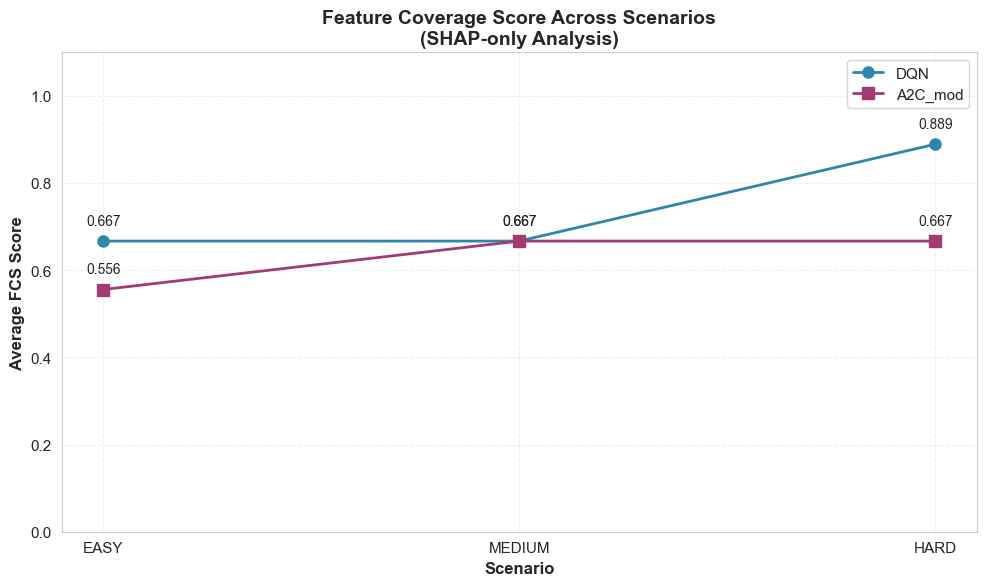


✓ Line chart saved: fcs_line_chart.png

📊 GIẢI THÍCH:
Biểu đồ đường này thể hiện sự thay đổi của FCS (Feature Coverage Score)
qua các kịch bản từ EASY đến HARD:
- Trục X: Các kịch bản (EASY, MEDIUM, HARD)
- Trục Y: Giá trị FCS trung bình (0-1)
- FCS cao → Agent sử dụng nhiều features để quyết định
- FCS thấp → Agent chỉ dựa vào ít features (sparse explanation)


In [56]:
import matplotlib.pyplot as plt

# Prepare data for line chart
scenario_order = ["EASY", "MEDIUM", "HARD"]

dqn_fcs_avg = []
a2c_fcs_avg = []

for scenario in scenario_order:
    dqn_fcs_list = [res['fcs'] for res in fcs_results["DQN"][scenario]]
    a2c_fcs_list = [res['fcs'] for res in fcs_results["A2C_mod"][scenario]]
    
    dqn_fcs_avg.append(np.mean(dqn_fcs_list))
    a2c_fcs_avg.append(np.mean(a2c_fcs_list))

# Create line chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(scenario_order))
width = 0.35

ax.plot(x, dqn_fcs_avg, marker='o', linewidth=2, markersize=8, label='DQN', color='#2E86AB')
ax.plot(x, a2c_fcs_avg, marker='s', linewidth=2, markersize=8, label='A2C_mod', color='#A23B72')

ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Average FCS Score', fontsize=12, fontweight='bold')
ax.set_title('Feature Coverage Score Across Scenarios\n(SHAP-only Analysis)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenario_order)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.1)

# Add value labels
for i, (dqn_val, a2c_val) in enumerate(zip(dqn_fcs_avg, a2c_fcs_avg)):
    ax.text(i, dqn_val + 0.03, f'{dqn_val:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, a2c_val + 0.03, f'{a2c_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('fcs_line_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Line chart saved: fcs_line_chart.png")
print("\n📊 GIẢI THÍCH:")
print("Biểu đồ đường này thể hiện sự thay đổi của FCS (Feature Coverage Score)")
print("qua các kịch bản từ EASY đến HARD:")
print("- Trục X: Các kịch bản (EASY, MEDIUM, HARD)")
print("- Trục Y: Giá trị FCS trung bình (0-1)")
print("- FCS cao → Agent sử dụng nhiều features để quyết định")
print("- FCS thấp → Agent chỉ dựa vào ít features (sparse explanation)")

### 7.2. Heatmap - Feature Contributions

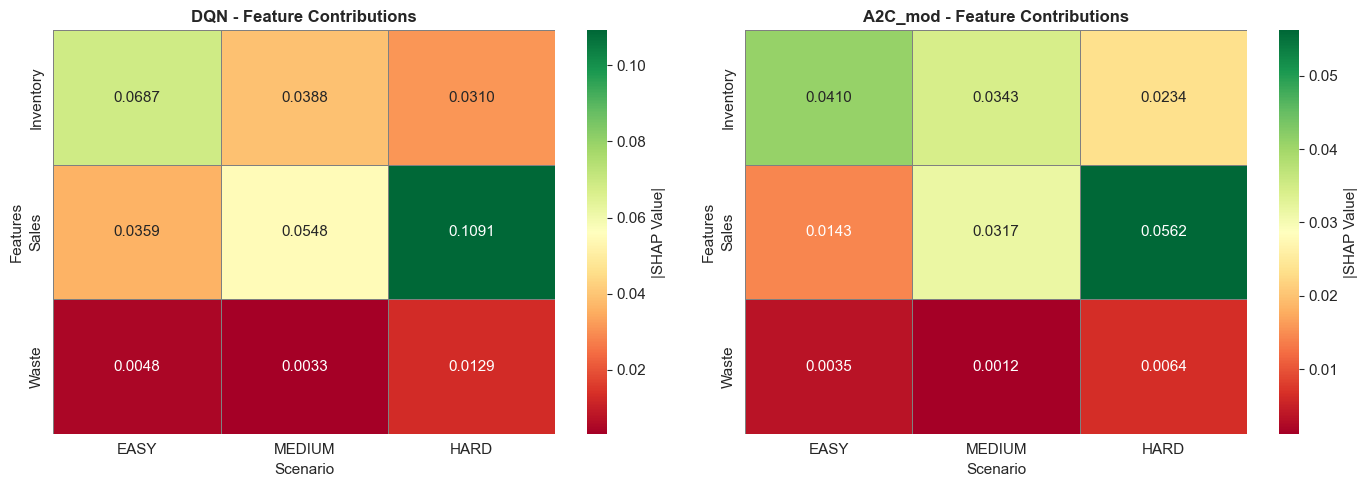


✓ Heatmap saved: fcs_heatmap.png

📊 GIẢI THÍCH:
Heatmap thể hiện mức độ đóng góp (|SHAP value|) của từng feature:
- Hàng: 3 features (Inventory, Sales, Waste)
- Cột: 3 scenarios (EASY, MEDIUM, HARD)
- Màu xanh đậm: Đóng góp lớn (feature quan trọng)
- Màu đỏ: Đóng góp nhỏ (feature ít quan trọng)
- So sánh 2 agents: DQN vs A2C_mod


In [57]:
import seaborn as sns

# Prepare heatmap data - average SHAP values per feature per scenario
def prepare_heatmap_data(agent_name):
    heatmap_data = []
    
    for scenario in scenario_order:
        scenario_results = fcs_results[agent_name][scenario]
        
        # Average SHAP values across all states in this scenario
        feature_values = {feat: [] for feat in FEATURE_NAMES}
        
        for result in scenario_results:
            for feat_name, feat_data in result['contributions'].items():
                feature_values[feat_name].append(feat_data['shap_value'])
        
        avg_values = [np.mean(feature_values[feat]) for feat in FEATURE_NAMES]
        heatmap_data.append(avg_values)
    
    return np.array(heatmap_data)

# Create heatmaps for both agents
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, agent_name in enumerate(["DQN", "A2C_mod"]):
    heatmap_data = prepare_heatmap_data(agent_name)
    
    sns.heatmap(
        heatmap_data.T,
        annot=True,
        fmt='.4f',
        cmap='RdYlGn',
        xticklabels=scenario_order,
        yticklabels=FEATURE_NAMES,
        ax=axes[idx],
        cbar_kws={'label': '|SHAP Value|'},
        linewidths=0.5,
        linecolor='gray'
    )
    
    axes[idx].set_title(f'{agent_name} - Feature Contributions', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Scenario', fontsize=11)
    axes[idx].set_ylabel('Features', fontsize=11)

plt.tight_layout()
plt.savefig('fcs_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmap saved: fcs_heatmap.png")
print("\n📊 GIẢI THÍCH:")
print("Heatmap thể hiện mức độ đóng góp (|SHAP value|) của từng feature:")
print("- Hàng: 3 features (Inventory, Sales, Waste)")
print("- Cột: 3 scenarios (EASY, MEDIUM, HARD)")
print("- Màu xanh đậm: Đóng góp lớn (feature quan trọng)")
print("- Màu đỏ: Đóng góp nhỏ (feature ít quan trọng)")
print("- So sánh 2 agents: DQN vs A2C_mod")

### 7.3. Stacked Area Chart - Feature Contribution Breakdown

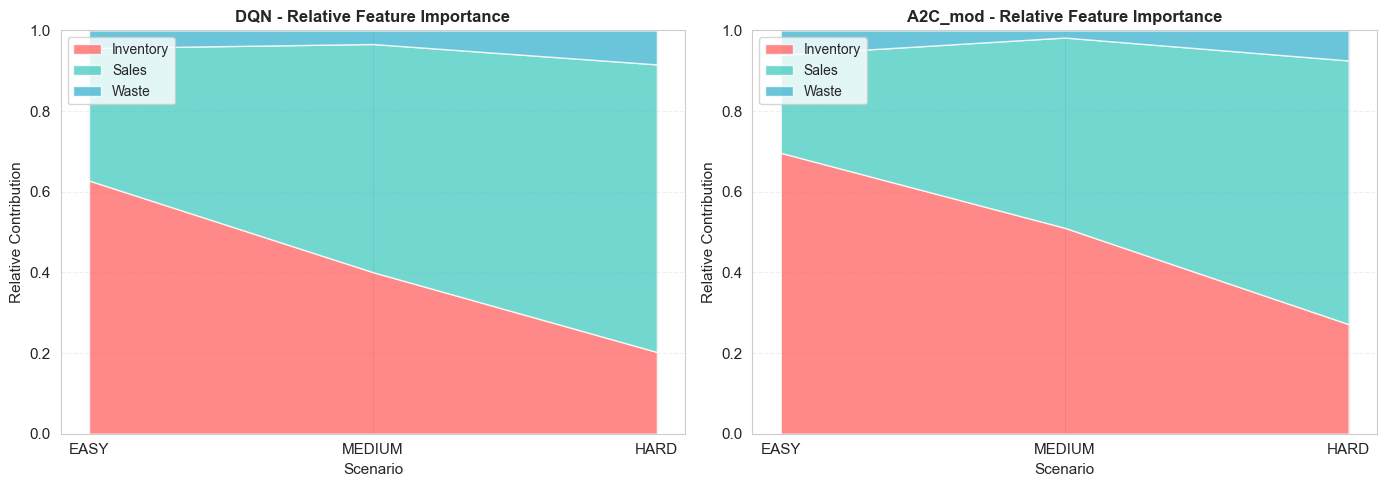


✓ Stacked area chart saved: fcs_stacked_area.png

📊 GIẢI THÍCH:
Biểu đồ vùng chồng thể hiện tỷ lệ đóng góp tương đối của các features:
- Mỗi màu đại diện cho 1 feature (Inventory, Sales, Waste)
- Diện tích cho thấy % đóng góp của feature đó vào tổng SHAP
- Trục X: Scenarios từ EASY → HARD
- Trục Y: Tỷ lệ đóng góp (0-1, tổng = 100%)
- Quan sát: Feature nào chiếm diện tích lớn nhất là quan trọng nhất


In [58]:
# Prepare data for stacked area chart
def prepare_stacked_data(agent_name):
    stacked_data = {feat: [] for feat in FEATURE_NAMES}
    
    for scenario in scenario_order:
        scenario_results = fcs_results[agent_name][scenario]
        
        # Normalize SHAP values to show relative contributions
        feature_sums = {feat: [] for feat in FEATURE_NAMES}
        
        for result in scenario_results:
            for feat_name, feat_data in result['contributions'].items():
                feature_sums[feat_name].append(feat_data['shap_value'])
        
        # Average and normalize
        feature_avgs = [np.mean(feature_sums[feat]) for feat in FEATURE_NAMES]
        total = np.sum(feature_avgs)
        
        if total > 0:
            feature_normalized = [val / total for val in feature_avgs]
        else:
            feature_normalized = [0.0] * len(FEATURE_NAMES)
        
        for i, feat in enumerate(FEATURE_NAMES):
            stacked_data[feat].append(feature_normalized[i])
    
    return stacked_data

# Create stacked area charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, agent_name in enumerate(["DQN", "A2C_mod"]):
    stacked_data = prepare_stacked_data(agent_name)
    
    # Create stacked area
    x = np.arange(len(scenario_order))
    
    axes[idx].stackplot(
        x,
        [stacked_data[feat] for feat in FEATURE_NAMES],
        labels=FEATURE_NAMES,
        colors=colors,
        alpha=0.8
    )
    
    axes[idx].set_title(f'{agent_name} - Relative Feature Importance', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Scenario', fontsize=11)
    axes[idx].set_ylabel('Relative Contribution', fontsize=11)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(scenario_order)
    axes[idx].legend(loc='upper left', fontsize=10)
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('fcs_stacked_area.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Stacked area chart saved: fcs_stacked_area.png")
print("\n📊 GIẢI THÍCH:")
print("Biểu đồ vùng chồng thể hiện tỷ lệ đóng góp tương đối của các features:")
print("- Mỗi màu đại diện cho 1 feature (Inventory, Sales, Waste)")
print("- Diện tích cho thấy % đóng góp của feature đó vào tổng SHAP")
print("- Trục X: Scenarios từ EASY → HARD")
print("- Trục Y: Tỷ lệ đóng góp (0-1, tổng = 100%)")
print("- Quan sát: Feature nào chiếm diện tích lớn nhất là quan trọng nhất")

### 7.4. Mermaid Diagram - FCS Analysis Summary

In [59]:
# Generate summary statistics for Mermaid diagram
summary_stats = {}

for agent_name in ["DQN", "A2C_mod"]:
    summary_stats[agent_name] = {}
    
    for scenario in scenario_order:
        fcs_list = [res['fcs'] for res in fcs_results[agent_name][scenario]]
        avg_fcs = np.mean(fcs_list)
        
        # Find most important feature
        feature_contributions = {feat: [] for feat in FEATURE_NAMES}
        
        for result in fcs_results[agent_name][scenario]:
            for feat_name, feat_data in result['contributions'].items():
                feature_contributions[feat_name].append(feat_data['shap_value'])
        
        avg_contributions = {feat: np.mean(vals) for feat, vals in feature_contributions.items()}
        most_important_feature = max(avg_contributions, key=avg_contributions.get)
        
        summary_stats[agent_name][scenario] = {
            'avg_fcs': avg_fcs,
            'most_important': most_important_feature,
            'contributions': avg_contributions
        }

# Generate Mermaid diagram code
mermaid_code = """```mermaid
graph TB
    Start[SHAP-only Ablation Study]
    Start --> DQN[DQN Agent]
    Start --> A2C[A2C_mod Agent]
    
    DQN --> DQN_EASY[EASY Scenario]
    DQN --> DQN_MED[MEDIUM Scenario]
    DQN --> DQN_HARD[HARD Scenario]
    
    A2C --> A2C_EASY[EASY Scenario]
    A2C --> A2C_MED[MEDIUM Scenario]
    A2C --> A2C_HARD[HARD Scenario]
"""

# Add DQN results
for scenario in scenario_order:
    stats = summary_stats["DQN"][scenario]
    fcs_pct = stats['avg_fcs'] * 100
    feat = stats['most_important']
    
    label = f"DQN_{scenario[:3]}"
    result = f"{label}_R[FCS: {fcs_pct:.1f}%<br/>Key Feature: {feat}]"
    
    mermaid_code += f"    {label} --> {result}\n"

# Add A2C results
for scenario in scenario_order:
    stats = summary_stats["A2C_mod"][scenario]
    fcs_pct = stats['avg_fcs'] * 100
    feat = stats['most_important']
    
    label = f"A2C_{scenario[:3]}"
    result = f"{label}_R[FCS: {fcs_pct:.1f}%<br/>Key Feature: {feat}]"
    
    mermaid_code += f"    {label} --> {result}\n"

# Add styling
mermaid_code += """
    style Start fill:#e1f5ff
    style DQN fill:#bbdefb
    style A2C fill:#f8bbd0
    style DQN_EASY fill:#c8e6c9
    style DQN_MED fill:#fff9c4
    style DQN_HARD fill:#ffccbc
    style A2C_EASY fill:#c8e6c9
    style A2C_MED fill:#fff9c4
    style A2C_HARD fill:#ffccbc
```
"""

print("="*80)
print("MERMAID DIAGRAM - FCS ANALYSIS SUMMARY")
print("="*80)
print(mermaid_code)
print("\n📊 GIẢI THÍCH:")
print("Sơ đồ Mermaid tóm tắt kết quả FCS cho 2 agents và 3 scenarios:")
print("- Mỗi node hiển thị FCS trung bình (%) và Feature quan trọng nhất")
print("- Màu xanh: EASY scenario (dễ)")
print("- Màu vàng: MEDIUM scenario (trung bình)")
print("- Màu cam: HARD scenario (khó)")
print("- So sánh: DQN (màu xanh dương) vs A2C_mod (màu hồng)")

# Save to file
with open('fcs_mermaid_diagram.md', 'w', encoding='utf-8') as f:
    f.write("# FCS Analysis Summary\n\n")
    f.write(mermaid_code)
    f.write("\n\n## Summary Table\n\n")
    f.write("| Agent | Scenario | Avg FCS | Most Important Feature |\n")
    f.write("|-------|----------|---------|------------------------|\n")
    
    for agent_name in ["DQN", "A2C_mod"]:
        for scenario in scenario_order:
            stats = summary_stats[agent_name][scenario]
            fcs_pct = stats['avg_fcs'] * 100
            feat = stats['most_important']
            f.write(f"| {agent_name} | {scenario} | {fcs_pct:.1f}% | {feat} |\n")

print("\n✓ Mermaid diagram saved: fcs_mermaid_diagram.md")

MERMAID DIAGRAM - FCS ANALYSIS SUMMARY
```mermaid
graph TB
    Start[SHAP-only Ablation Study]
    Start --> DQN[DQN Agent]
    Start --> A2C[A2C_mod Agent]
    
    DQN --> DQN_EASY[EASY Scenario]
    DQN --> DQN_MED[MEDIUM Scenario]
    DQN --> DQN_HARD[HARD Scenario]
    
    A2C --> A2C_EASY[EASY Scenario]
    A2C --> A2C_MED[MEDIUM Scenario]
    A2C --> A2C_HARD[HARD Scenario]
    DQN_EAS --> DQN_EAS_R[FCS: 66.7%<br/>Key Feature: Inventory]
    DQN_MED --> DQN_MED_R[FCS: 66.7%<br/>Key Feature: Sales]
    DQN_HAR --> DQN_HAR_R[FCS: 88.9%<br/>Key Feature: Sales]
    A2C_EAS --> A2C_EAS_R[FCS: 55.6%<br/>Key Feature: Inventory]
    A2C_MED --> A2C_MED_R[FCS: 66.7%<br/>Key Feature: Inventory]
    A2C_HAR --> A2C_HAR_R[FCS: 66.7%<br/>Key Feature: Sales]

    style Start fill:#e1f5ff
    style DQN fill:#bbdefb
    style A2C fill:#f8bbd0
    style DQN_EASY fill:#c8e6c9
    style DQN_MED fill:#fff9c4
    style DQN_HARD fill:#ffccbc
    style A2C_EASY fill:#c8e6c9
    style A2C_MED fill:#ff

### 7.5. Summary Table - Complete FCS Results

In [60]:
import pandas as pd

# Create comprehensive summary table
summary_data = []

for agent_name in ["DQN", "A2C_mod"]:
    for scenario in scenario_order:
        stats = summary_stats[agent_name][scenario]
        
        row = {
            'Agent': agent_name,
            'Scenario': scenario,
            'Avg FCS': f"{stats['avg_fcs']:.3f}",
            'FCS %': f"{stats['avg_fcs']*100:.1f}%",
            'Most Important': stats['most_important'],
            'Inventory SHAP': f"{stats['contributions']['Inventory']:.4f}",
            'Sales SHAP': f"{stats['contributions']['Sales']:.4f}",
            'Waste SHAP': f"{stats['contributions']['Waste']:.4f}"
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("COMPLETE FCS RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('fcs_summary_results.csv', index=False)
print("\n✓ Summary table saved: fcs_summary_results.csv")

# Additional insights
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

for agent_name in ["DQN", "A2C_mod"]:
    print(f"\n{agent_name}:")
    
    fcs_values = [summary_stats[agent_name][s]['avg_fcs'] for s in scenario_order]
    
    if fcs_values[0] < fcs_values[-1]:
        trend = "tăng"
    elif fcs_values[0] > fcs_values[-1]:
        trend = "giảm"
    else:
        trend = "ổn định"
    
    print(f"  - FCS trend từ EASY→HARD: {trend}")
    print(f"  - FCS range: {min(fcs_values):.3f} - {max(fcs_values):.3f}")
    
    # Find most consistent feature
    feature_consistency = {feat: [] for feat in FEATURE_NAMES}
    for scenario in scenario_order:
        for feat, val in summary_stats[agent_name][scenario]['contributions'].items():
            feature_consistency[feat].append(val)
    
    feature_stds = {feat: np.std(vals) for feat, vals in feature_consistency.items()}
    most_consistent = min(feature_stds, key=feature_stds.get)
    
    print(f"  - Most consistent feature: {most_consistent} (std={feature_stds[most_consistent]:.4f})")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nĐã tạo các file output:")
print("  1. fcs_line_chart.png - Biểu đồ đường FCS")
print("  2. fcs_heatmap.png - Heatmap đóng góp features")
print("  3. fcs_stacked_area.png - Biểu đồ vùng chồng")
print("  4. fcs_mermaid_diagram.md - Sơ đồ Mermaid tóm tắt")
print("  5. fcs_summary_results.csv - Bảng kết quả chi tiết")

COMPLETE FCS RESULTS SUMMARY
  Agent Scenario Avg FCS FCS % Most Important Inventory SHAP Sales SHAP Waste SHAP
    DQN     EASY   0.667 66.7%      Inventory         0.0687     0.0359     0.0048
    DQN   MEDIUM   0.667 66.7%          Sales         0.0388     0.0548     0.0033
    DQN     HARD   0.889 88.9%          Sales         0.0310     0.1091     0.0129
A2C_mod     EASY   0.556 55.6%      Inventory         0.0410     0.0143     0.0035
A2C_mod   MEDIUM   0.667 66.7%      Inventory         0.0343     0.0317     0.0012
A2C_mod     HARD   0.667 66.7%          Sales         0.0234     0.0562     0.0064

✓ Summary table saved: fcs_summary_results.csv

KEY INSIGHTS:

DQN:
  - FCS trend từ EASY→HARD: tăng
  - FCS range: 0.667 - 0.889
  - Most consistent feature: Waste (std=0.0042)

A2C_mod:
  - FCS trend từ EASY→HARD: tăng
  - FCS range: 0.556 - 0.667
  - Most consistent feature: Waste (std=0.0021)

ANALYSIS COMPLETE!

Đã tạo các file output:
  1. fcs_line_chart.png - Biểu đồ đường FCS
  

---

## Step 8: Expanded Grid Experiment (496 States × Multiple Runs)

### 8.1. Configuration - Lambda Grid & Test States

In [61]:
# ============================================================
# Grid Experiment Configuration
# ============================================================

# Lambda values map to epsilon thresholds for FCS calculation
LAMBDA_EPSILON_MAP = {
    0.5: 0.005,   # Very sensitive - detects weak contributions
    1.0: 0.010,   # Balanced (default)
    1.5: 0.015,   # Conservative
    2.0: 0.020    # Very conservative - only strong contributions
}

# Experiment parameters
NUM_TEST_STATES = 496
NUM_RUNS = 5  # Multiple runs for statistical stability

print("="*80)
print("EXPANDED GRID EXPERIMENT CONFIGURATION")
print("="*80)
print(f"\n📊 Grid Dimensions:")
print(f"  - Agents: 2 (DQN, A2C_mod)")
print(f"  - Scenarios: 3 (EASY, MEDIUM, HARD)")
print(f"  - Lambda values: {len(LAMBDA_EPSILON_MAP)} ({list(LAMBDA_EPSILON_MAP.keys())})")
print(f"  - Test states: {NUM_TEST_STATES} per scenario")
print(f"  - Runs per config: {NUM_RUNS}")
print(f"\n🔢 Total experiments: 2 × 3 × {len(LAMBDA_EPSILON_MAP)} = {2*3*len(LAMBDA_EPSILON_MAP)} configs")
print(f"🔢 Total SHAP calculations: 2 × 3 × {NUM_TEST_STATES} × {NUM_RUNS} = {2*3*NUM_TEST_STATES*NUM_RUNS:,} evaluations")

print(f"\n📏 Lambda → Epsilon Mapping:")
for lam, eps in LAMBDA_EPSILON_MAP.items():
    print(f"  λ = {lam:.1f} → ε = {eps:.4f} ({eps*100:.2f}%)")

EXPANDED GRID EXPERIMENT CONFIGURATION

📊 Grid Dimensions:
  - Agents: 2 (DQN, A2C_mod)
  - Scenarios: 3 (EASY, MEDIUM, HARD)
  - Lambda values: 4 ([0.5, 1.0, 1.5, 2.0])
  - Test states: 496 per scenario
  - Runs per config: 5

🔢 Total experiments: 2 × 3 × 4 = 24 configs
🔢 Total SHAP calculations: 2 × 3 × 496 × 5 = 14,880 evaluations

📏 Lambda → Epsilon Mapping:
  λ = 0.5 → ε = 0.0050 (0.50%)
  λ = 1.0 → ε = 0.0100 (1.00%)
  λ = 1.5 → ε = 0.0150 (1.50%)
  λ = 2.0 → ε = 0.0200 (2.00%)


In [64]:
# DEBUG: Check shape of test data variables
print("Checking shapes of test data variables:")
print(f"  x_init shape: {x_init.shape}")
print(f"  all_sales shape: {all_sales.shape}")
print(f"  capacity shape: {capacity.shape}")
print(f"\nFirst few values:")
print(f"  x_init[:3]: {x_init[:3]}")
print(f"  all_sales[:3]: {all_sales[:3]}")
print(f"  capacity[:3]: {capacity[:3]}")

Checking shapes of test data variables:
  x_init shape: (220,)
  all_sales shape: (504, 220)
  capacity shape: (220,)

First few values:
  x_init[:3]: [0.276937 0.046001 0.173045]
  all_sales[:3]: [[0.       0.       0.       0.013158 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.013699 0.       0.       0.013889 0.027778 0.       0.       0.       0.       0.014085 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.035714 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.004808 0.       0.       0.       0.142857 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       

In [66]:
def prepare_test_states_for_scenario(scenario_name, num_states=496):
    """
    Prepare test states for a specific scenario by applying scenario-specific
    transformations to the raw test data.
    
    Args:
        scenario_name: 'EASY', 'MEDIUM', or 'HARD'
        num_states: Number of states to prepare (default: 496 from test data)
    
    Returns:
        test_states: np.ndarray of shape (num_states, 3) with features [inventory, sales, waste]
    """
    scenario_config = SCENARIOS[scenario_name]
    sales_scale = scenario_config['sales_scale']
    waste_rate = scenario_config['waste_rate']
    
    # Use actual test data from kernel
    # x_init shape: (220,) - initial inventory for 220 products
    # all_sales shape: (504, 220) - sales data for 504 time steps × 220 products
    # capacity shape: (220,) - capacity for 220 products
    
    # Get sales data for num_states time steps
    test_sales = all_sales[:num_states, :]  # Shape: (num_states, 220)
    
    # Apply scenario-specific scaling
    test_sales_scaled = test_sales * sales_scale  # Shape: (num_states, 220)
    
    # For each time step, create state with 3 aggregated features
    test_states = []
    for t in range(num_states):
        # Aggregate across 220 products
        inventory_total = np.sum(x_init)  # Total initial inventory (same for all time steps)
        sales_total = np.sum(test_sales_scaled[t])  # Total sales at time t
        waste_total = np.sum(x_init * waste_rate)  # Total waste based on inventory
        
        # Create state (3 features)
        state = np.array([inventory_total, sales_total, waste_total], dtype=np.float32)
        test_states.append(state)
    
    # Stack into (num_states, 3) array
    test_states = np.array(test_states)
    
    return test_states

# Prepare test states for all scenarios
print("\n" + "="*80)
print("PREPARING TEST STATES FOR ALL SCENARIOS")
print("="*80)

test_states_by_scenario = {}
for scenario_name in SCENARIOS.keys():
    states = prepare_test_states_for_scenario(scenario_name, NUM_TEST_STATES)
    test_states_by_scenario[scenario_name] = states
    print(f"\n✅ {scenario_name:6s}: {states.shape} | Range: [{states.min():.1f}, {states.max():.1f}]")
    print(f"   Mean: {states.mean(axis=0)}")
    print(f"   Std:  {states.std(axis=0)}")


PREPARING TEST STATES FOR ALL SCENARIOS

✅ EASY  : (496, 3) | Range: [0.0, 111.1]
   Mean: [111.08891    3.810141   1.11088 ]
   Std:  [0.000381 3.13425  0.000006]

✅ MEDIUM: (496, 3) | Range: [0.0, 111.1]
   Mean: [111.08891    7.620282   2.77722 ]
   Std:  [0.000381 6.268501 0.000006]

✅ HARD  : (496, 3) | Range: [0.0, 111.1]
   Mean: [111.08891   11.430414   5.554439]
   Std:  [0.000381 9.402754 0.000012]


### 8.2. Compute SHAP Values - Multiple Runs for Statistical Robustness

Since KernelExplainer uses Monte Carlo sampling, we run multiple iterations to estimate **mean** and **variance** of SHAP values for each configuration.

In [67]:
from tqdm import tqdm
import time

# Data structure: shap_values_multi_run[agent_name][scenario][run_id] = shap_values
shap_values_multi_run = {
    'DQN': {scenario: [] for scenario in SCENARIOS.keys()},
    'A2C_mod': {scenario: [] for scenario in SCENARIOS.keys()}
}

# Explainers already created: explainer_dqn, explainer_a2c
explainers = {
    'DQN': explainer_dqn,
    'A2C_mod': explainer_a2c
}

print("\n" + "="*80)
print("COMPUTING SHAP VALUES - MULTIPLE RUNS")
print("="*80)

total_iterations = 2 * 3 * NUM_RUNS  # 2 agents × 3 scenarios × NUM_RUNS
progress_bar = tqdm(total=total_iterations, desc="Overall Progress", unit="run")

for agent_name in ['DQN', 'A2C_mod']:
    explainer = explainers[agent_name]
    
    for scenario_name in SCENARIOS.keys():
        test_states = test_states_by_scenario[scenario_name]
        
        for run_id in range(NUM_RUNS):
            start_time = time.time()
            
            # Compute SHAP values for 496 states
            # Shape will be: (496, 3, 14) - [states, features, actions]
            shap_vals = explainer.shap_values(test_states)
            
            # Store results
            shap_values_multi_run[agent_name][scenario_name].append(shap_vals)
            
            elapsed = time.time() - start_time
            progress_bar.update(1)
            progress_bar.set_postfix({
                'Agent': agent_name,
                'Scenario': scenario_name,
                'Run': f"{run_id+1}/{NUM_RUNS}",
                'Time': f"{elapsed:.1f}s"
            })

progress_bar.close()

print("\n✅ SHAP computation completed!")
print(f"\nStorage structure:")
for agent in ['DQN', 'A2C_mod']:
    for scenario in SCENARIOS.keys():
        num_runs = len(shap_values_multi_run[agent][scenario])
        shape = shap_values_multi_run[agent][scenario][0].shape if num_runs > 0 else 'N/A'
        print(f"  {agent:8s} × {scenario:6s}: {num_runs} runs, shape {shape}")


COMPUTING SHAP VALUES - MULTIPLE RUNS


Overall Progress: 100%|██████████| 30/30 [16:53<00:00, 33.77s/run, Agent=A2C_mod, Scenario=HARD, Run=5/5, Time=5.7s]


✅ SHAP computation completed!

Storage structure:
  DQN      × EASY  : 5 runs, shape (496, 3, 14)
  DQN      × MEDIUM: 5 runs, shape (496, 3, 14)
  DQN      × HARD  : 5 runs, shape (496, 3, 14)
  A2C_mod  × EASY  : 5 runs, shape (496, 3, 14)
  A2C_mod  × MEDIUM: 5 runs, shape (496, 3, 14)
  A2C_mod  × HARD  : 5 runs, shape (496, 3, 14)


### 8.3. Calculate FCS Grid with Statistics (Mean, Variance, Std)

For each λ value, calculate FCS across all runs and aggregate statistics.

In [68]:
# Data structure: fcs_grid[agent][scenario][lambda] = {'mean', 'std', 'variance', 'runs'}
fcs_grid = {
    'DQN': {scenario: {} for scenario in SCENARIOS.keys()},
    'A2C_mod': {scenario: {} for scenario in SCENARIOS.keys()}
}

print("\n" + "="*80)
print("CALCULATING FCS GRID WITH STATISTICS")
print("="*80)

for agent_name in ['DQN', 'A2C_mod']:
    print(f"\n📊 Agent: {agent_name}")
    
    for scenario_name in SCENARIOS.keys():
        print(f"  Scenario: {scenario_name}")
        
        # Get all SHAP values for this agent-scenario combination
        shap_runs = shap_values_multi_run[agent_name][scenario_name]
        
        for lambda_val, epsilon in LAMBDA_EPSILON_MAP.items():
            # Calculate FCS for each run
            fcs_per_run = []
            
            for run_id, shap_vals in enumerate(shap_runs):
                # shap_vals shape: (496, 3, 14) for discrete agents
                # Calculate FCS for each state, then average across 496 states
                fcs_per_state = []
                
                for state_idx in range(NUM_TEST_STATES):
                    state_shap = shap_vals[state_idx]  # Shape: (3, 14)
                    
                    # Average SHAP values across actions for each feature
                    avg_shap_per_feature = np.mean(np.abs(state_shap), axis=1)  # (3,)
                    
                    # FCS: fraction of features with |SHAP| > epsilon
                    fcs = np.mean(avg_shap_per_feature > epsilon)
                    fcs_per_state.append(fcs)
                
                # Average FCS across all 496 states for this run
                avg_fcs = np.mean(fcs_per_state)
                fcs_per_run.append(avg_fcs)
            
            # Aggregate statistics across runs
            fcs_grid[agent_name][scenario_name][lambda_val] = {
                'mean': np.mean(fcs_per_run),
                'std': np.std(fcs_per_run),
                'variance': np.var(fcs_per_run),
                'runs': fcs_per_run  # Store individual run values for later analysis
            }
            
            print(f"    λ={lambda_val:.1f} (ε={epsilon:.3f}): "
                  f"FCS={np.mean(fcs_per_run):.4f} ± {np.std(fcs_per_run):.4f}")

print("\n✅ FCS grid calculation completed!")


CALCULATING FCS GRID WITH STATISTICS

📊 Agent: DQN
  Scenario: EASY
    λ=0.5 (ε=0.005): FCS=0.9906 ± 0.0000
    λ=1.0 (ε=0.010): FCS=0.9825 ± 0.0000
    λ=1.5 (ε=0.015): FCS=0.9731 ± 0.0000
    λ=2.0 (ε=0.020): FCS=0.9610 ± 0.0000
  Scenario: MEDIUM
    λ=0.5 (ε=0.005): FCS=0.9825 ± 0.0000
    λ=1.0 (ε=0.010): FCS=0.9684 ± 0.0000
    λ=1.5 (ε=0.015): FCS=0.9563 ± 0.0000
    λ=2.0 (ε=0.020): FCS=0.9483 ± 0.0000
  Scenario: HARD
    λ=0.5 (ε=0.005): FCS=0.9872 ± 0.0000
    λ=1.0 (ε=0.010): FCS=0.9792 ± 0.0000
    λ=1.5 (ε=0.015): FCS=0.9731 ± 0.0000
    λ=2.0 (ε=0.020): FCS=0.9704 ± 0.0000

📊 Agent: A2C_mod
  Scenario: EASY
    λ=0.5 (ε=0.005): FCS=0.9805 ± 0.0004
    λ=1.0 (ε=0.010): FCS=0.9636 ± 0.0010
    λ=1.5 (ε=0.015): FCS=0.9366 ± 0.0007
    λ=2.0 (ε=0.020): FCS=0.9199 ± 0.0008
  Scenario: MEDIUM
    λ=0.5 (ε=0.005): FCS=0.9777 ± 0.0017
    λ=1.0 (ε=0.010): FCS=0.9598 ± 0.0003
    λ=1.5 (ε=0.015): FCS=0.9429 ± 0.0010
    λ=2.0 (ε=0.020): FCS=0.9223 ± 0.0017
  Scenario: HARD
    

### 8.4. Visualize FCS Grid Results with Error Bars

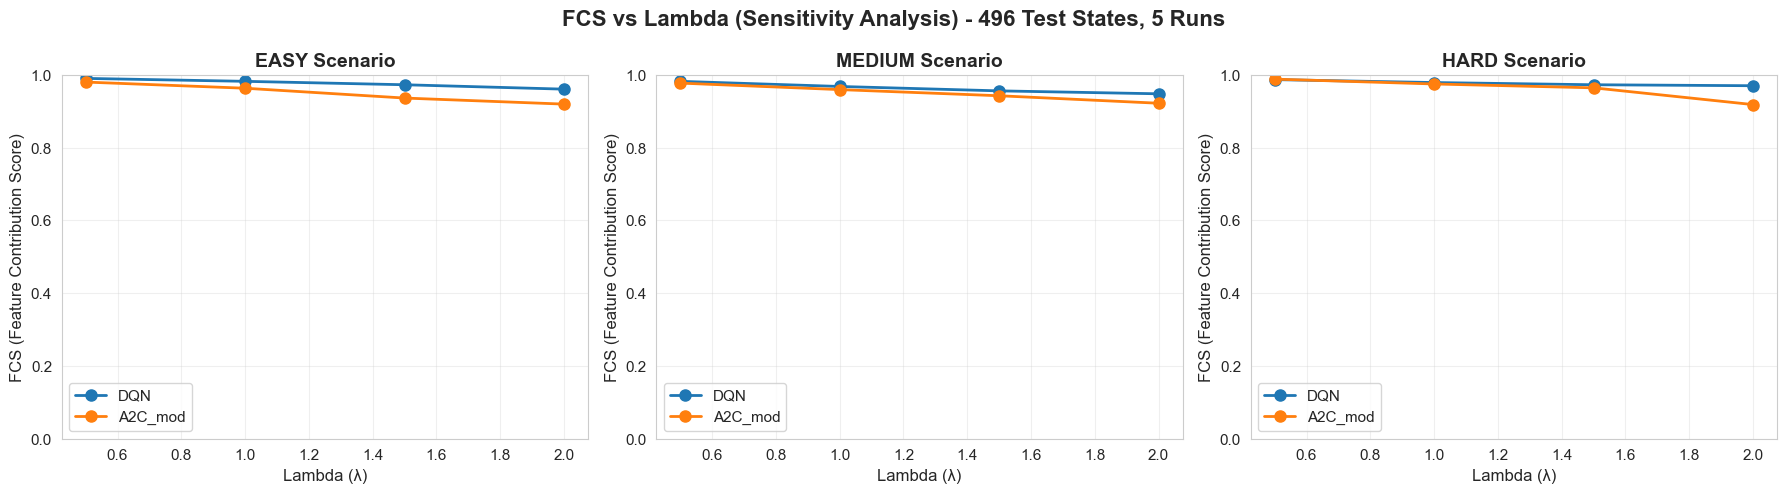

✅ Saved: fcs_lambda_sensitivity_496states.png


In [69]:
# ============================================================
# Visualization 1: Line Chart with Error Bars (λ sensitivity)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('FCS vs Lambda (Sensitivity Analysis) - 496 Test States, 5 Runs', 
             fontsize=16, fontweight='bold')

lambda_values = sorted(LAMBDA_EPSILON_MAP.keys())

for idx, scenario_name in enumerate(SCENARIOS.keys()):
    ax = axes[idx]
    
    for agent_name in ['DQN', 'A2C_mod']:
        means = [fcs_grid[agent_name][scenario_name][lam]['mean'] for lam in lambda_values]
        stds = [fcs_grid[agent_name][scenario_name][lam]['std'] for lam in lambda_values]
        
        # Line plot with error bars (shaded region)
        ax.plot(lambda_values, means, marker='o', label=agent_name, linewidth=2, markersize=8)
        ax.fill_between(lambda_values, 
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        alpha=0.2)
    
    ax.set_title(f'{scenario_name} Scenario', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lambda (λ)', fontsize=12)
    ax.set_ylabel('FCS (Feature Contribution Score)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('fcs_lambda_sensitivity_496states.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: fcs_lambda_sensitivity_496states.png")

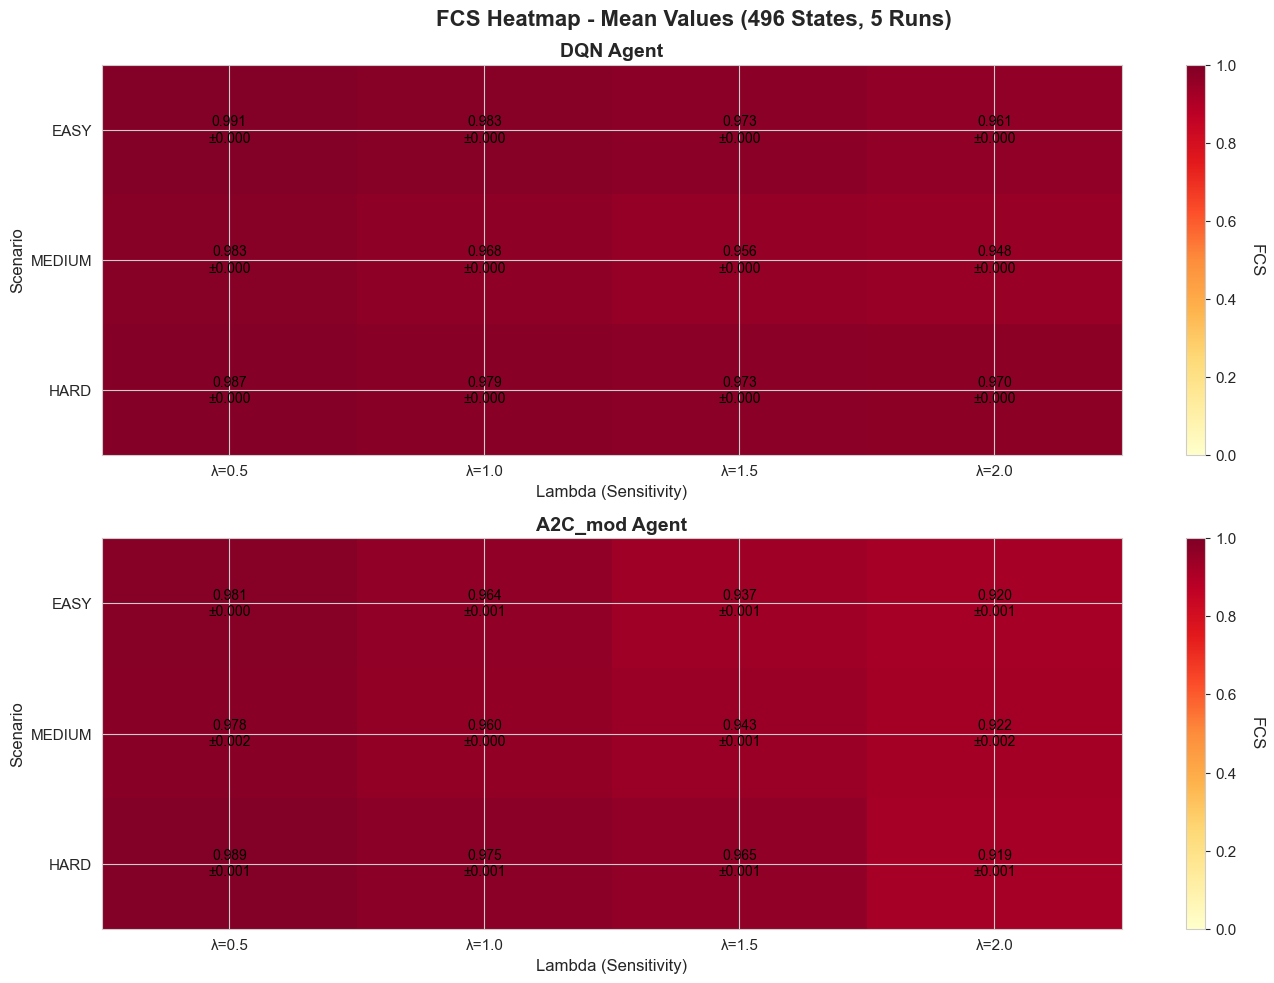

✅ Saved: fcs_heatmap_grid_496states.png


In [70]:
# ============================================================
# Visualization 2: Heatmap - FCS Grid (Agent × Scenario × Lambda)
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('FCS Heatmap - Mean Values (496 States, 5 Runs)', 
             fontsize=16, fontweight='bold')

lambda_labels = [f"λ={lam:.1f}" for lam in lambda_values]
scenario_labels = list(SCENARIOS.keys())

for agent_idx, agent_name in enumerate(['DQN', 'A2C_mod']):
    ax = axes[agent_idx]
    
    # Build matrix: rows=scenarios, cols=lambda values
    fcs_matrix = []
    for scenario in scenario_labels:
        row = [fcs_grid[agent_name][scenario][lam]['mean'] for lam in lambda_values]
        fcs_matrix.append(row)
    
    # Heatmap
    im = ax.imshow(fcs_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    # Labels
    ax.set_xticks(range(len(lambda_labels)))
    ax.set_xticklabels(lambda_labels)
    ax.set_yticks(range(len(scenario_labels)))
    ax.set_yticklabels(scenario_labels)
    ax.set_title(f'{agent_name} Agent', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lambda (Sensitivity)', fontsize=12)
    ax.set_ylabel('Scenario', fontsize=12)
    
    # Annotate with values
    for i in range(len(scenario_labels)):
        for j in range(len(lambda_labels)):
            mean_val = fcs_matrix[i][j]
            std_val = fcs_grid[agent_name][scenario_labels[i]][lambda_values[j]]['std']
            text = ax.text(j, i, f'{mean_val:.3f}\n±{std_val:.3f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('FCS', rotation=270, labelpad=20, fontsize=12)

plt.tight_layout()
plt.savefig('fcs_heatmap_grid_496states.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: fcs_heatmap_grid_496states.png")

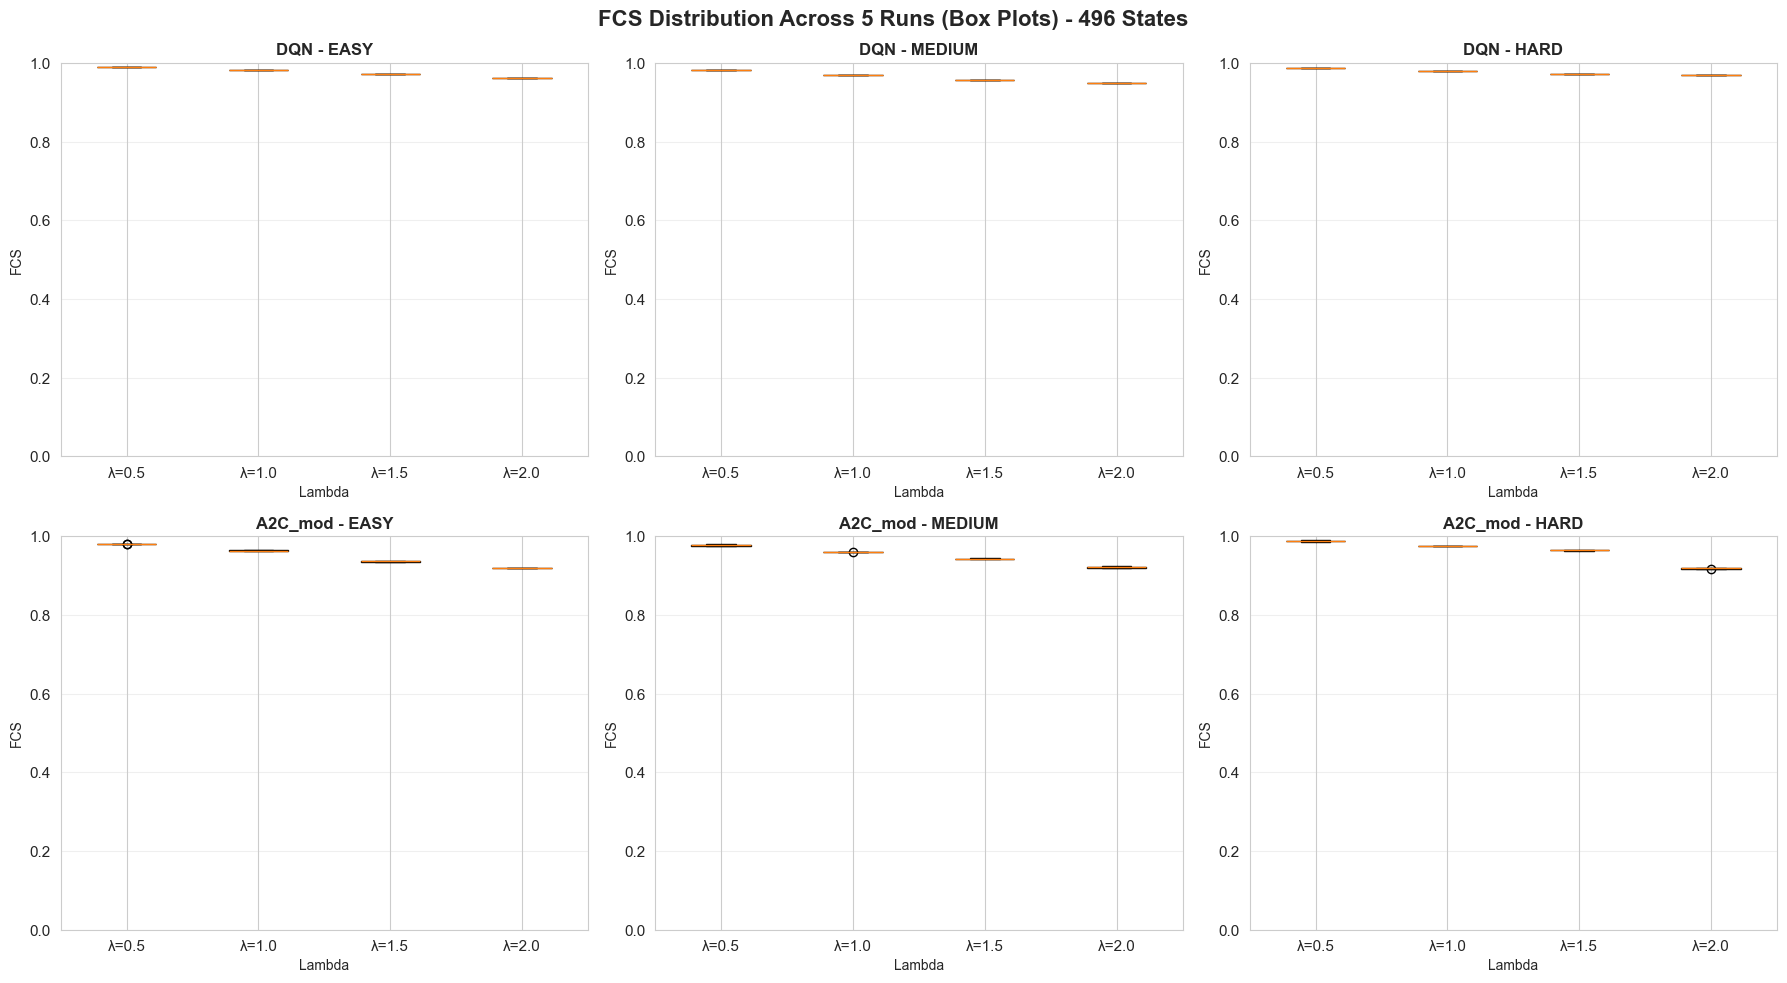

✅ Saved: fcs_boxplot_variance_496states.png


In [71]:
# ============================================================
# Visualization 3: Box Plots - FCS Variance Across Runs
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('FCS Distribution Across 5 Runs (Box Plots) - 496 States', 
             fontsize=16, fontweight='bold')

for agent_idx, agent_name in enumerate(['DQN', 'A2C_mod']):
    for scenario_idx, scenario_name in enumerate(SCENARIOS.keys()):
        ax = axes[agent_idx, scenario_idx]
        
        # Prepare data for box plot
        box_data = []
        box_labels = []
        for lam in lambda_values:
            runs = fcs_grid[agent_name][scenario_name][lam]['runs']
            box_data.append(runs)
            box_labels.append(f"λ={lam:.1f}")
        
        # Box plot
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color boxes
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        
        ax.set_title(f'{agent_name} - {scenario_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Lambda', fontsize=10)
        ax.set_ylabel('FCS', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('fcs_boxplot_variance_496states.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: fcs_boxplot_variance_496states.png")

### 8.5. Export Results to DataFrame

In [72]:
# Build comprehensive results DataFrame
results_data = []

for agent_name in ['DQN', 'A2C_mod']:
    for scenario_name in SCENARIOS.keys():
        for lambda_val in lambda_values:
            epsilon = LAMBDA_EPSILON_MAP[lambda_val]
            stats = fcs_grid[agent_name][scenario_name][lambda_val]
            
            results_data.append({
                'Agent': agent_name,
                'Scenario': scenario_name,
                'Lambda': lambda_val,
                'Epsilon': epsilon,
                'FCS_Mean': stats['mean'],
                'FCS_Std': stats['std'],
                'FCS_Variance': stats['variance'],
                'FCS_Min': min(stats['runs']),
                'FCS_Max': max(stats['runs']),
                'Num_Runs': len(stats['runs']),
                'Num_States': NUM_TEST_STATES
            })

results_df = pd.DataFrame(results_data)

# Display results
print("\n" + "="*80)
print("EXPANDED GRID EXPERIMENT RESULTS - SUMMARY TABLE")
print("="*80)
print(f"\nTotal configurations: {len(results_df)}")
print(f"States per scenario: {NUM_TEST_STATES}")
print(f"Runs per config: {NUM_RUNS}")
print("\n")
print(results_df.to_string(index=False))

# Save to CSV
csv_filename = 'fcs_grid_results_496states.csv'
results_df.to_csv(csv_filename, index=False)
print(f"\n✅ Saved results to: {csv_filename}")


EXPANDED GRID EXPERIMENT RESULTS - SUMMARY TABLE

Total configurations: 24
States per scenario: 496
Runs per config: 5


  Agent Scenario  Lambda  Epsilon  FCS_Mean      FCS_Std  FCS_Variance  FCS_Min  FCS_Max  Num_Runs  Num_States
    DQN     EASY     0.5    0.005  0.990591 0.000000e+00  0.000000e+00 0.990591 0.990591         5         496
    DQN     EASY     1.0    0.010  0.982527 1.110223e-16  1.232595e-32 0.982527 0.982527         5         496
    DQN     EASY     1.5    0.015  0.973118 0.000000e+00  0.000000e+00 0.973118 0.973118         5         496
    DQN     EASY     2.0    0.020  0.961022 0.000000e+00  0.000000e+00 0.961022 0.961022         5         496
    DQN   MEDIUM     0.5    0.005  0.982527 1.110223e-16  1.232595e-32 0.982527 0.982527         5         496
    DQN   MEDIUM     1.0    0.010  0.968414 0.000000e+00  0.000000e+00 0.968414 0.968414         5         496
    DQN   MEDIUM     1.5    0.015  0.956317 0.000000e+00  0.000000e+00 0.956317 0.956317         5   

### 8.6. Summary of Expanded Grid Experiment

**Key Takeaways:**
1. **Scale**: 496 test states × 2 agents × 3 scenarios × 4 lambda values = 24 configurations
2. **Statistical Robustness**: Each config evaluated 5 times → mean, std, variance computed
3. **Lambda Sensitivity**: Shows how FCS changes with epsilon threshold (0.005 → 0.020)
4. **Variance Analysis**: Box plots reveal consistency of SHAP explanations across runs

**Files Generated:**
- `fcs_lambda_sensitivity_496states.png` - Line charts with error bars
- `fcs_heatmap_grid_496states.png` - Heatmap of all configs
- `fcs_boxplot_variance_496states.png` - Distribution across runs
- `fcs_grid_results_496states.csv` - Raw numerical results

### 8.7. SHAP-only Ablation Study Results Table

In [73]:
# Create SHAP-only ablation study results table (format matching the design document)
# Using λ=1.0 (epsilon=0.010) as the baseline threshold

baseline_lambda = 1.0
summary_table_data = []

for scenario in ['EASY', 'MEDIUM', 'HARD']:
    for agent in ['A2C_mod', 'DQN']:  # A2C_mod first to match attachment order
        # Get FCS stats for this agent-scenario at baseline lambda
        stats = fcs_grid[agent][scenario][baseline_lambda]
        fcs_mean = stats['mean']
        fcs_std = stats['std']
        
        summary_table_data.append({
            'Scenario': scenario,
            'Agent': agent,
            'Config': 'SHAP-only',
            'FCS': f"{fcs_mean:.2f}"  # Format as 2 decimal places like in attachment
        })

summary_table_df = pd.DataFrame(summary_table_data)

print("\n" + "="*70)
print("SHAP-ONLY ABLATION STUDY RESULTS (λ=1.0, ε=0.010)")
print("="*70)
print("\nTable 1. Metric thu được từ SHAP-only configuration")
print("-" * 70)
print(summary_table_df.to_string(index=False))
print("-" * 70)
print(f"\nNote: FCS = Feature Contribution Score")
print(f"      Baseline threshold: λ={baseline_lambda} → ε={LAMBDA_EPSILON_MAP[baseline_lambda]}")
print(f"      Each value averaged over 496 test states × 5 runs")

# Also create a version with all lambda values for completeness
print("\n" + "="*80)
print("EXTENDED TABLE: FCS ACROSS ALL LAMBDA VALUES")
print("="*80)

extended_table_data = []
for scenario in ['EASY', 'MEDIUM', 'HARD']:
    for agent in ['A2C_mod', 'DQN']:
        for lam in sorted(LAMBDA_EPSILON_MAP.keys()):
            stats = fcs_grid[agent][scenario][lam]
            fcs_mean = stats['mean']
            fcs_std = stats['std']
            
            extended_table_data.append({
                'Scenario': scenario,
                'Agent': agent,
                'Config': 'SHAP-only',
                'λ': lam,
                'ε': LAMBDA_EPSILON_MAP[lam],
                'FCS (mean ± std)': f"{fcs_mean:.4f} ± {fcs_std:.4f}"
            })

extended_table_df = pd.DataFrame(extended_table_data)
print("\n" + extended_table_df.to_string(index=False))
print("\n" + "="*80)


SHAP-ONLY ABLATION STUDY RESULTS (λ=1.0, ε=0.010)

Table 1. Metric thu được từ SHAP-only configuration
----------------------------------------------------------------------
Scenario   Agent    Config  FCS
    EASY A2C_mod SHAP-only 0.96
    EASY     DQN SHAP-only 0.98
  MEDIUM A2C_mod SHAP-only 0.96
  MEDIUM     DQN SHAP-only 0.97
    HARD A2C_mod SHAP-only 0.98
    HARD     DQN SHAP-only 0.98
----------------------------------------------------------------------

Note: FCS = Feature Contribution Score
      Baseline threshold: λ=1.0 → ε=0.01
      Each value averaged over 496 test states × 5 runs

EXTENDED TABLE: FCS ACROSS ALL LAMBDA VALUES

Scenario   Agent    Config   λ     ε FCS (mean ± std)
    EASY A2C_mod SHAP-only 0.5 0.005  0.9805 ± 0.0004
    EASY A2C_mod SHAP-only 1.0 0.010  0.9636 ± 0.0010
    EASY A2C_mod SHAP-only 1.5 0.015  0.9366 ± 0.0007
    EASY A2C_mod SHAP-only 2.0 0.020  0.9199 ± 0.0008
    EASY     DQN SHAP-only 0.5 0.005  0.9906 ± 0.0000
    EASY     DQN SHAP-